# 研究ミーティング 9/22
## やったこと
- Qulacs によるシミュレーション
    - 3 regular (16頂点 & 18頂点) ランダムグラフ(10種類) における MaxCut を 3-1 QRAO で解く。
    - entanglement は linear, compatible, random の 3種類を実行
    - level は 0 (no entanglement) から 9 まで試した。
    - Optimizer は CobylaOptimizer, max_iter=25000
    - Rounding は shot=1000

## 今後の方針
- Pauli rounding をやれば差が出る可能性がある。
- graph の大きさをもっとあげないと差が出ないかも (40node くらい)
- graph の density をあげて試してみる
- weighted にしてみる
- NFT algorithm + EfficientSU2 に移行
    - NFT algorithm for non-EfficientSU2 (論文あり)

- 3,2 にすればビット数が増えるが、近似率は改善するのでは？

## memo
- ハミルトニアンの最小固有値と固有状態を求めてそれをデコードしてみる。(VQE をやらないで)
    - 16, 18 node なら計算可能
    - 今の ansatz が local optimum に入っている可能性
    - VQE で見つかったものが実際の状態と Fidelity でどのくらい離れているかを計算して改めて linear, compatible, random で比較してみる。

- (14, 16, 18, 20) nodes, (3, 4, 5, 6) deg, (0, 1, 2, 3, 4) layer

- rounding の実装がおかしい可能性 (最優先でチェック)

In [3]:
import pickle
from networkx import node_link_graph, draw


def load_results(
    deg: int,
    num_nodes: int,
    num_trials: int,
    num_levels: int,
    dir_name: str = "results",
):
    graphs = []
    compatible_results = []
    linear_results = []
    random_results = []
    root_path = f"/work/gs54/s54005/qrao_experiment/{dir_name}/regular/deg{deg}/nodes{num_nodes}/"

    for trial in range(num_trials):
        trial_path = root_path + f"trial{trial}/"
        with open(trial_path + "graph_data.pkl", "rb") as file:
            data = pickle.load(file)
        graph = node_link_graph(data)
        graphs.append(graph)
        compatible_result = []
        linear_result = []
        random_result = []
        compatible_root = trial_path + "3-1/compatible/"
        linear_root = trial_path + "3-1/linear/"
        random_root = trial_path + "3-1/random/"

        for level in range(num_levels):
            with open(compatible_root + f"level{level}.pkl", "rb") as file:
                compatible = pickle.load(file)
            with open(linear_root + f"level{level}.pkl", "rb") as file:
                linear = pickle.load(file)
            with open(random_root + f"level{level}.pkl", "rb") as file:
                random = pickle.load(file)
            compatible_result.append(compatible)
            linear_result.append(linear)
            random_result.append(random)

        compatible_results.append(compatible_result)
        linear_results.append(linear_result)
        random_results.append(random_result)

    return graphs, compatible_results, linear_results, random_results

In [4]:
def calc_exp(maxcut_values):
    shots = 1000
    sum_val = 0
    for key, val in maxcut_values.items():
        sum_val += key * val
    return sum_val / shots


def get_mean(values):
    values_mean = []
    for level in range(len(values[0])):
        sum_val = 0
        for instance in range(len(values)):
            sum_val += values[instance][level]
        sum_val /= len(values)
        values_mean.append(sum_val)
    return values_mean

In [5]:
from collections import defaultdict
from tqdm.auto import tqdm

graphs_dict = defaultdict(lambda: {}, {})
compatible_results_dict = defaultdict(lambda: {}, {})
linear_results_dict = defaultdict(lambda: {}, {})
random_results_dict = defaultdict(lambda: {}, {})

degs = [4]
num_nodes_list = [14, 18, 22, 26, 30]
num_trials = 10
num_levels = 5
dir_name = "results"

for deg in tqdm(degs):
    for num_nodes in tqdm(num_nodes_list):
        graphs, compatible_results, linear_results, random_results = load_results(
            deg, num_nodes, num_trials, num_levels, dir_name
        )
        graphs_dict[deg][num_nodes] = graphs
        compatible_results_dict[deg][num_nodes] = compatible_results
        linear_results_dict[deg][num_nodes] = linear_results
        random_results_dict[deg][num_nodes] = random_results

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
def extract_vqe_eigvals(results_dict, deg, num_nodes):
    results = results_dict[deg][num_nodes]
    eigvals_list = []
    for result in results:
        eigvals = []
        for level_result in result:
            eigvals.append(level_result["eigvals"])
        eigvals_list.append(eigvals)
    return eigvals_list


def extract_vqe_cost_history(results_dict, deg, num_nodes):
    results = results_dict[deg][num_nodes]
    cost_history_list = []
    for result in results:
        cost_history = []
        for level_result in result:
            cost_history.append(level_result["cost_history"])
        cost_history_list.append(cost_history)
    return cost_history_list

In [18]:
eigvals_dict = defaultdict(lambda: {}, {})
cost_history_compatible_dict = defaultdict(lambda: {}, {})
cost_history_linear_dict = defaultdict(lambda: {}, {})
cost_history_random_dict = defaultdict(lambda: {}, {})
for deg in tqdm(degs):
    for num_nodes in tqdm(num_nodes_list):
        compatible_eigvals = extract_vqe_eigvals(
            compatible_results_dict, deg, num_nodes
        )
        # TODO: it's better to take assertion here.
        eigvals_dict[deg][num_nodes] = compatible_eigvals
        cost_history_compatible_dict[deg][num_nodes] = extract_vqe_cost_history(
            compatible_results_dict, deg, num_nodes
        )
        cost_history_linear_dict[deg][num_nodes] = extract_vqe_cost_history(
            linear_results_dict, deg, num_nodes
        )
        cost_history_random_dict[deg][num_nodes] = extract_vqe_cost_history(
            random_results_dict, deg, num_nodes
        )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [48]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_relax_maxcut_results(deg: int, num_nodes: int, num_trial: int = 0):
    # load values
    eigvals = eigvals_dict[deg][num_nodes][num_trial]
    compatible_history = cost_history_compatible_dict[deg][num_nodes][num_trial]
    linear_history = cost_history_linear_dict[deg][num_nodes][num_trial]
    random_history = cost_history_random_dict[deg][num_nodes][num_trial]

    min_eigval = eigvals[0][0]
    second_min_eigval = eigvals[0][1]
    third_min_eigval = eigvals[0][2]
    forth_min_eigval = eigvals[0][3]
    compatible_history_for_plot = [hist[-1] for hist in compatible_history]
    linear_history_for_plot = [hist[-1] for hist in linear_history]
    random_history_for_plot = [hist[-1] for hist in random_history]

    plt.rcParams["font.size"] = 10
    plt.plot(compatible_history_for_plot, color="green", label="compatible")
    plt.plot(linear_history_for_plot, color="red", label="linear")
    plt.plot(random_history_for_plot, color="orange", label="random")
    plt.plot(
        [min_eigval for _ in range(len(compatible_history_for_plot))],
        color="black",
        label="min relax cut",
        linestyle="dashed",
    )
    plt.plot(
        [second_min_eigval for _ in range(len(compatible_history_for_plot))],
        color="gray",
        label="2nd min relax cut",
        linestyle="dashdot",
    )
    plt.plot(
        [third_min_eigval for _ in range(len(compatible_history_for_plot))],
        color="blue",
        label="3rd min relax cut",
        linestyle="dotted",
    )
    plt.plot(
        [forth_min_eigval for _ in range(len(compatible_history_for_plot))],
        color="purple",
        label="4th relax cut",
        linestyle="dashed",
    )
 
    plt.xticks([i for i in range(num_levels)])
    plt.xlabel("Num of entanglement layer")
    plt.ylabel("Relax maxcut value")
    plt.legend()
    plt.show()

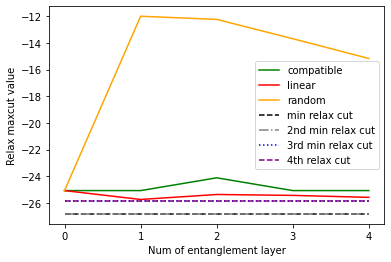

In [52]:
plot_relax_maxcut_results(4, 14, 0)

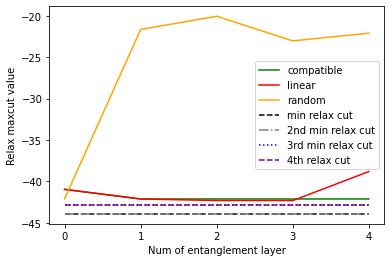

In [53]:
plot_relax_maxcut_results(4, 22, 0)

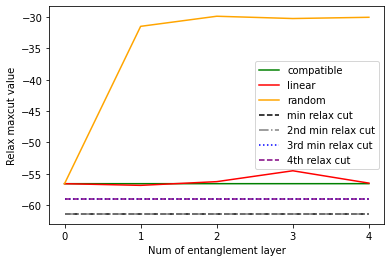

In [54]:
plot_relax_maxcut_results(4, 30, 0)

In [5]:
def calc_statistics(
    graphs_dict,
    compatible_results_dict,
    linear_results_dict,
    random_results_dict,
    deg,
    num_nodes,
):
    compatible_values_max_pauli = []
    linear_values_max_pauli = []
    random_values_max_pauli = []
    compatible_values_max_magic = []
    linear_values_max_magic = []
    random_values_max_magic = []
    compatible_values_exp_magic = []
    linear_values_exp_magic = []
    random_values_exp_magic = []
    compatible_values_freq_magic = []
    linear_values_freq_magic = []
    random_values_freq_magic = []
    opt_values = []

    graphs = graphs_dict[deg][num_nodes]
    compatible_results = compatible_results_dict[deg][num_nodes]
    linear_results = linear_results_dict[deg][num_nodes]
    random_results = random_results_dict[deg][num_nodes]

    # iteration for instances
    for graph, compatible_result, linear_result, random_result in zip(
        graphs, compatible_results, linear_results, random_results
    ):
        opt_value = -1
        compatible_value_max_pauli = []
        linear_value_max_pauli = []
        random_value_max_pauli = []
        compatible_value_max_magic = []
        linear_value_max_magic = []
        random_value_max_magic = []
        compatible_value_exp_magic = []
        linear_value_exp_magic = []
        random_value_exp_magic = []
        compatible_value_freq_magic = []
        linear_value_freq_magic = []
        random_value_freq_magic = []

        # iteration for levels
        for compatible, linear, random in zip(
            compatible_result, linear_result, random_result
        ):
            compatible_maxcut_max_pauli = compatible["maxcut_value_pauli"]
            linear_maxcut_max_pauli = linear["maxcut_value_pauli"]
            random_maxcut_max_pauli = random["maxcut_value_pauli"]
            compatible_maxcut_max_magic = max(
                list(compatible["maxcut_values_magic"].keys())
            )
            linear_maxcut_max_magic = max(list(linear["maxcut_values_magic"].keys()))
            random_maxcut_max_magic = max(list(random["maxcut_values_magic"].keys()))
            compatible_maxcut_exp_magic = calc_exp(compatible["maxcut_values_magic"])
            linear_maxcut_exp_magic = calc_exp(linear["maxcut_values_magic"])
            random_maxcut_exp_magic = calc_exp(random["maxcut_values_magic"])
            compatible_maxcut_freq_magic = list(
                compatible["maxcut_values_magic"].keys()
            )[0]
            linear_maxcut_freq_magic = list(linear["maxcut_values_magic"].keys())[0]
            random_maxcut_freq_magic = list(random["maxcut_values_magic"].keys())[0]
            assert (
                compatible["optimum_solution"]
                == linear["optimum_solution"]
                == random["optimum_solution"]
            )
            assert opt_value == -1 or opt_value == compatible["optimum_solution"]
            opt_value = max(opt_value, compatible["optimum_solution"])
            compatible_value_max_pauli.append(compatible_maxcut_max_pauli)
            linear_value_max_pauli.append(linear_maxcut_max_pauli)
            random_value_max_pauli.append(random_maxcut_max_pauli)
            compatible_value_max_magic.append(compatible_maxcut_max_magic)
            linear_value_max_magic.append(linear_maxcut_max_magic)
            random_value_max_magic.append(random_maxcut_max_magic)
            compatible_value_exp_magic.append(compatible_maxcut_exp_magic)
            linear_value_exp_magic.append(linear_maxcut_exp_magic)
            random_value_exp_magic.append(random_maxcut_exp_magic)
            compatible_value_freq_magic.append(compatible_maxcut_freq_magic)
            linear_value_freq_magic.append(linear_maxcut_freq_magic)
            random_value_freq_magic.append(random_maxcut_freq_magic)

        compatible_values_max_pauli.append(compatible_value_max_pauli)
        linear_values_max_pauli.append(linear_value_max_pauli)
        random_values_max_pauli.append(random_value_max_pauli)
        compatible_values_max_magic.append(compatible_value_max_magic)
        linear_values_max_magic.append(linear_value_max_magic)
        random_values_max_magic.append(random_value_max_magic)
        compatible_values_exp_magic.append(compatible_value_exp_magic)
        linear_values_exp_magic.append(linear_value_exp_magic)
        random_values_exp_magic.append(random_value_exp_magic)
        compatible_values_freq_magic.append(compatible_value_freq_magic)
        linear_values_freq_magic.append(linear_value_freq_magic)
        random_values_freq_magic.append(random_value_freq_magic)
        opt_values.append(opt_value)

    return (
        compatible_values_max_pauli,
        linear_values_max_pauli,
        random_values_max_pauli,
        compatible_values_max_magic,
        linear_values_max_magic,
        random_values_max_magic,
        compatible_values_exp_magic,
        linear_values_exp_magic,
        random_values_exp_magic,
        compatible_values_freq_magic,
        linear_values_freq_magic,
        random_values_freq_magic,
        opt_values,
    )

In [6]:
compatible_values_max_pauli_dict = defaultdict(lambda: {}, {})
linear_values_max_pauli_dict = defaultdict(lambda: {}, {})
random_values_max_pauli_dict = defaultdict(lambda: {}, {})
compatible_values_max_magic_dict = defaultdict(lambda: {}, {})
linear_values_max_magic_dict = defaultdict(lambda: {}, {})
random_values_max_magic_dict = defaultdict(lambda: {}, {})
compatible_values_exp_magic_dict = defaultdict(lambda: {}, {})
linear_values_exp_magic_dict = defaultdict(lambda: {}, {})
random_values_exp_magic_dict = defaultdict(lambda: {}, {})
compatible_values_freq_magic_dict = defaultdict(lambda: {}, {})
linear_values_freq_magic_dict = defaultdict(lambda: {}, {})
random_values_freq_magic_dict = defaultdict(lambda: {}, {})
opt_values_dict = defaultdict(lambda: {}, {})

for deg in degs:
    for num_nodes in num_nodes_list:
        (
            compatible_values_max_pauli,
            linear_values_max_pauli,
            random_values_max_pauli,
            compatible_values_max_magic,
            linear_values_max_magic,
            random_values_max_magic,
            compatible_values_exp_magic,
            linear_values_exp_magic,
            random_values_exp_magic,
            compatible_values_freq_magic,
            linear_values_freq_magic,
            random_values_freq_magic,
            opt_values,
        ) = calc_statistics(
            graphs_dict,
            compatible_results_dict,
            linear_results_dict,
            random_results_dict,
            deg,
            num_nodes,
        )
        compatible_values_max_pauli_dict[deg][num_nodes] = compatible_values_max_pauli
        linear_values_max_pauli_dict[deg][num_nodes] = linear_values_max_pauli
        random_values_max_pauli_dict[deg][num_nodes] = random_values_max_pauli
        compatible_values_max_magic_dict[deg][num_nodes] = compatible_values_max_magic
        linear_values_max_magic_dict[deg][num_nodes] = linear_values_max_magic
        random_values_max_magic_dict[deg][num_nodes] = random_values_max_magic
        compatible_values_exp_magic_dict[deg][num_nodes] = compatible_values_exp_magic
        linear_values_exp_magic_dict[deg][num_nodes] = linear_values_exp_magic
        random_values_exp_magic_dict[deg][num_nodes] = random_values_exp_magic
        compatible_values_freq_magic_dict[deg][num_nodes] = compatible_values_freq_magic
        linear_values_freq_magic_dict[deg][num_nodes] = linear_values_freq_magic
        random_values_freq_magic_dict[deg][num_nodes] = random_values_freq_magic
        opt_values_dict[deg][num_nodes] = opt_values

In [7]:
def plot_maxcut_results(
    deg: int, num_nodes: int, calc_mean: bool = True, num_trial: int = 0
):
    # load calculated statistics
    compatible_values_max_pauli = compatible_values_max_pauli_dict[deg][num_nodes]
    linear_values_max_pauli = linear_values_max_pauli_dict[deg][num_nodes]
    random_values_max_pauli = random_values_max_pauli_dict[deg][num_nodes]
    compatible_values_max_magic = compatible_values_max_magic_dict[deg][num_nodes]
    linear_values_max_magic = linear_values_max_magic_dict[deg][num_nodes]
    random_values_max_magic = random_values_max_magic_dict[deg][num_nodes]
    compatible_values_exp_magic = compatible_values_exp_magic_dict[deg][num_nodes]
    linear_values_exp_magic = linear_values_exp_magic_dict[deg][num_nodes]
    random_values_exp_magic = random_values_exp_magic_dict[deg][num_nodes]
    compatible_values_freq_magic = compatible_values_freq_magic_dict[deg][num_nodes]
    linear_values_freq_magic = linear_values_freq_magic_dict[deg][num_nodes]
    random_values_freq_magic = random_values_freq_magic_dict[deg][num_nodes]
    opt_values = opt_values_dict[deg][num_nodes]

    if calc_mean:
        # calculate mean for instances
        compatible_values_max_pauli_for_plot = get_mean(compatible_values_max_pauli)
        linear_values_max_pauli_for_plot = get_mean(linear_values_max_pauli)
        random_values_max_pauli_for_plot = get_mean(random_values_max_pauli)
        compatible_values_max_magic_for_plot = get_mean(compatible_values_max_magic)
        linear_values_max_magic_for_plot = get_mean(linear_values_max_magic)
        random_values_max_magic_for_plot = get_mean(random_values_max_magic)
        compatible_values_exp_magic_for_plot = get_mean(compatible_values_exp_magic)
        linear_values_exp_magic_for_plot = get_mean(linear_values_exp_magic)
        random_values_exp_magic_for_plot = get_mean(random_values_exp_magic)
        compatible_values_freq_magic_for_plot = get_mean(compatible_values_freq_magic)
        linear_values_freq_magic_for_plot = get_mean(linear_values_freq_magic)
        random_values_freq_magic_for_plot = get_mean(random_values_freq_magic)

        # FIXME: fig this logic
        opt_values_for_plot = opt_values[0]

    else:
        # retrieve the result for the instance identified by num_trial
        compatible_values_max_pauli_for_plot = compatible_values_max_pauli[num_trial]
        linear_values_max_pauli_for_plot = linear_values_max_pauli[num_trial]
        random_values_max_pauli_for_plot = random_values_max_pauli[num_trial]
        compatible_values_max_magic_for_plot = compatible_values_max_magic[num_trial]
        linear_values_max_magic_for_plot = linear_values_max_magic[num_trial]
        random_values_max_magic_for_plot = random_values_max_magic[num_trial]
        compatible_values_exp_magic_for_plot = compatible_values_exp_magic[num_trial]
        linear_values_exp_magic_for_plot = linear_values_exp_magic[num_trial]
        random_values_exp_magic_for_plot = random_values_exp_magic[num_trial]
        compatible_values_freq_magic_for_plot = compatible_values_freq_magic[num_trial]
        linear_values_freq_magic_for_plot = linear_values_freq_magic[num_trial]
        random_values_freq_magic_for_plot = random_values_freq_magic[num_trial]
        opt_values_for_plot = opt_values[num_trial]

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 7))
    fig.suptitle("MaxCut values")

    ax1.plot(compatible_values_max_magic_for_plot, color="red", label="compatible")
    ax1.plot(linear_values_max_magic_for_plot, color="green", label="linear")
    ax1.plot(random_values_max_magic_for_plot, color="blue", label="random")
    ax1.plot(
        [opt_values_for_plot for i in range(len(compatible_values_max_magic_for_plot))],
        color="black",
        label="opt",
    )
    ax1.set_xlabel("Num of entanglement layers")
    ax1.set_ylabel("Found maxcut value (max)")
    ax1.legend()

    ax2.plot(compatible_values_exp_magic_for_plot, color="red", label="compatible")
    ax2.plot(linear_values_exp_magic_for_plot, color="green", label="linear")
    ax2.plot(random_values_exp_magic_for_plot, color="blue", label="random")
    ax2.plot(
        [opt_values_for_plot for i in range(len(compatible_values_max_magic_for_plot))],
        color="black",
        label="opt",
    )
    ax2.set_xlabel("Num of entanglement layers")
    ax2.set_ylabel("Found maxcut value (exp)")
    ax2.legend()

    ax3.plot(compatible_values_freq_magic_for_plot, color="red", label="compatible")
    ax3.plot(linear_values_freq_magic_for_plot, color="green", label="linear")
    ax3.plot(random_values_freq_magic_for_plot, color="blue", label="random")
    ax3.plot(
        [opt_values_for_plot for i in range(len(compatible_values_max_magic_for_plot))],
        color="black",
        label="opt",
    )
    ax3.set_xlabel("Num of entanglement layers")
    ax3.set_ylabel("Found maxcut value (freq)")
    ax3.legend()

    ax4.plot(
        compatible_values_max_pauli_for_plot,
        color="red",
        label="Pauli Rounding (compatible)",
    )
    ax4.plot(
        compatible_values_max_magic_for_plot,
        color="blue",
        label="Magic Rounding (compatible)",
    )
    ax4.plot(
        [opt_values_for_plot for i in range(len(compatible_values_max_magic_for_plot))],
        color="black",
        label="opt",
    )
    ax4.set_xlabel("Num of entanglement layers")
    ax4.set_ylabel("Found maxcut value (max)")
    ax4.legend()

    ax5.plot(
        linear_values_max_pauli_for_plot, color="red", label="Pauli Rounding (linear)"
    )
    ax5.plot(
        linear_values_max_magic_for_plot, color="blue", label="Magic Rounding (linear)"
    )
    ax5.plot(
        [opt_values_for_plot for i in range(len(compatible_values_max_magic_for_plot))],
        color="black",
        label="opt",
    )
    ax5.set_xlabel("Num of entanglement layers")
    ax5.set_ylabel("Found maxcut value (max)")
    ax5.legend()

    ax6.plot(
        random_values_max_pauli_for_plot, color="red", label="Pauli Rounding (random)"
    )
    ax6.plot(
        random_values_max_magic_for_plot, color="blue", label="Magic Rounding (random)"
    )
    ax6.plot(
        [opt_values_for_plot for i in range(len(compatible_values_max_magic_for_plot))],
        color="black",
        label="opt",
    )
    ax6.set_xlabel("Num of entanglement layers")
    ax6.set_ylabel("Found maxcut value (max)")
    ax6.legend()

    fig.show()

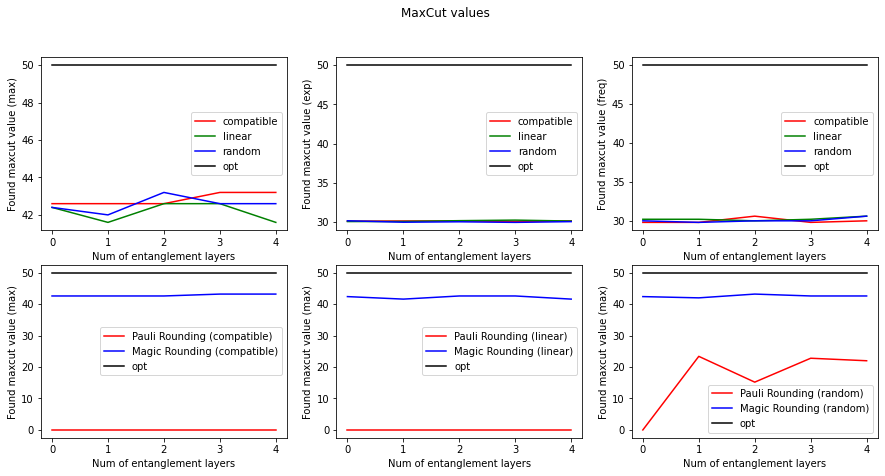

In [8]:
plot_results(4, 30, True)

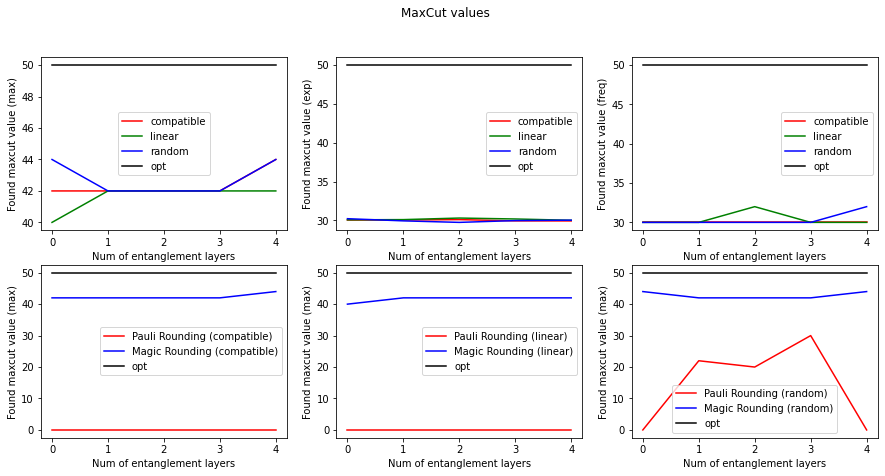

In [16]:
plot_results(4, 30, False, 5)